In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [49]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='dark')

In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.testing_lib as testing_lib

### Find the desired model

In [244]:
config_dir = '/home/kbolat/Python/behavio-temporal-vae/runs/visual_Aug09_16-20-51'
config_file = 'config.json'

with open(os.path.join(config_dir, config_file), 'r') as f: config = json.load(f)

In [245]:
trainset, valset, conditioner, user_ids, condition_set, X_test, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Number of (subsampled/filtered) users....6830
Number of (subsampled) days...............365
Number of (aggregated) features............24
Mean of enrolments: 0.31
Number of Training Points: 2241493
Number of Validation Points: 249295
Number of Testing Points: 2162


In [246]:
num_users = len(num_missing_days)

In [247]:
## if there is no folder called visuals, create one
if not os.path.exists(os.path.join(config_dir, 'visuals')):
    os.makedirs(os.path.join(config_dir, 'visuals'))

#### Visualize the enrolments

In [248]:
## if there is no folder called enrolments under visuals, create one
if not os.path.exists(os.path.join(config_dir, 'visuals', 'enrolments')):
    os.makedirs(os.path.join(config_dir, 'visuals', 'enrolments'))

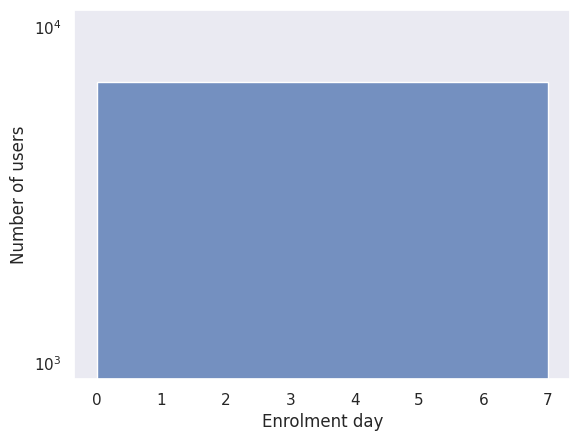

<Figure size 640x480 with 0 Axes>

In [251]:
h = sns.histplot(num_missing_days, binwidth=7)
h.set_yscale('log')
plt.xlabel('Enrolment day')
plt.ylabel('Number of users')
plt.show()
plt.savefig(os.path.join(config_dir, 'visuals', 'enrolments', 'enrolment_days.png'))

In [252]:
import matplotlib as mpl

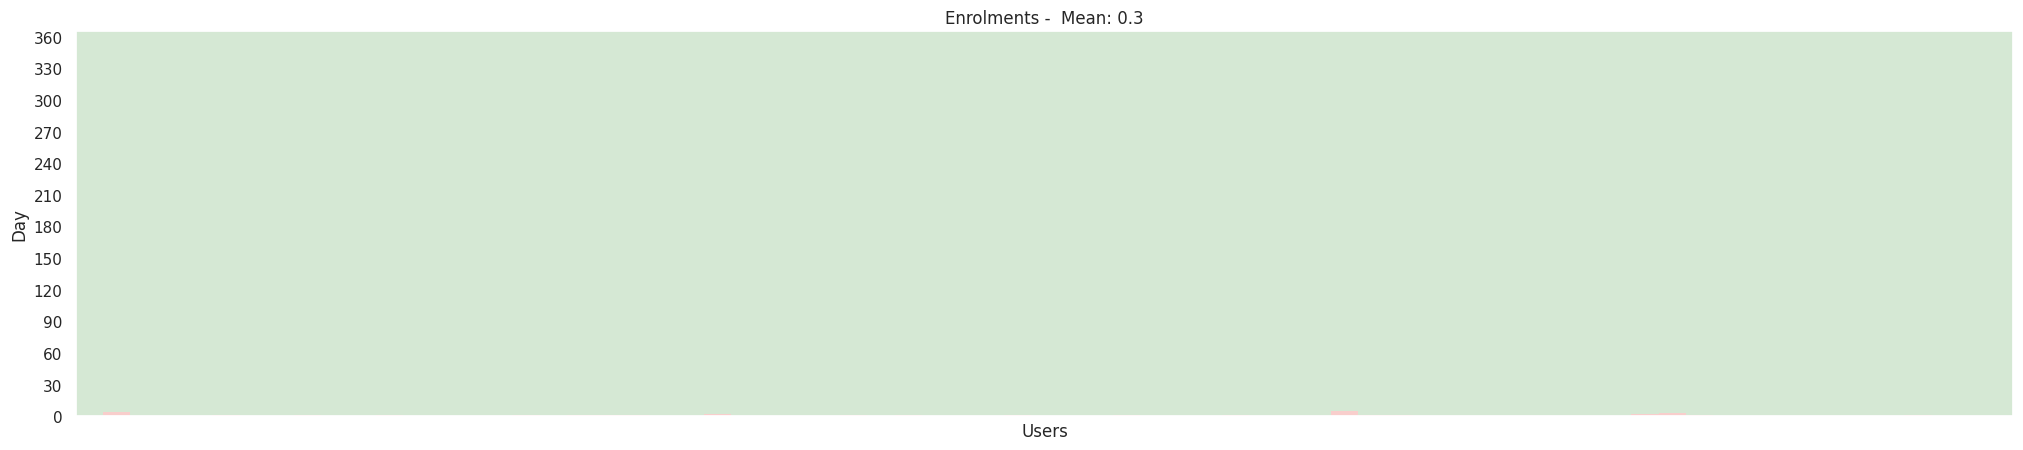

In [253]:
enrolment_matrix = np.zeros((num_users, 365))
for i in range(num_users): enrolment_matrix[i, num_missing_days[i]:] = 1

ssample = 97 ## for visualization
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
# sns.heatmap(enrolment_matrix[::ssample].T, ax=ax, cbar=False, cmap=[(248/255, 206/255, 204/255, 1), (213/255,232/255,212/255,1)])
plt.pcolormesh(enrolment_matrix[::ssample].T, cmap=mpl.colors.ListedColormap([(248/255, 206/255, 204/255, 1), (213/255,232/255,212/255,1)]))
ax.set_title(f"Enrolments -  Mean: {365/(1+config['data']['ampute_params']['b']/config['data']['ampute_params']['a']):.1f}")
ax.set_xlabel("Users")
ax.set_ylabel("Day")
# plt.gca().invert_yaxis() ## flip the y axis
plt.yticks(np.arange(0, 365, 30), np.arange(0, 365, 30))
plt.xticks([])
plt.savefig(os.path.join(config_dir, 'visuals', 'enrolments', 'enrolment_matrix.png'))
plt.show()


### Pattern dictionary

In [254]:
# Load model
model = CVAE(input_dim=valset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(config_dir)

USING SIGMA_LIM!
USING SIGMA_LIM!


In [255]:
## if there is no folder called pattern_dictionary under visuals, create one
if not os.path.exists(os.path.join(config_dir, 'visuals', 'pattern_dictionary')):
    os.makedirs(os.path.join(config_dir, 'visuals', 'pattern_dictionary'))

In [256]:
pattern_dictionary = model.decoder.get_SigmaMapper().detach().numpy()

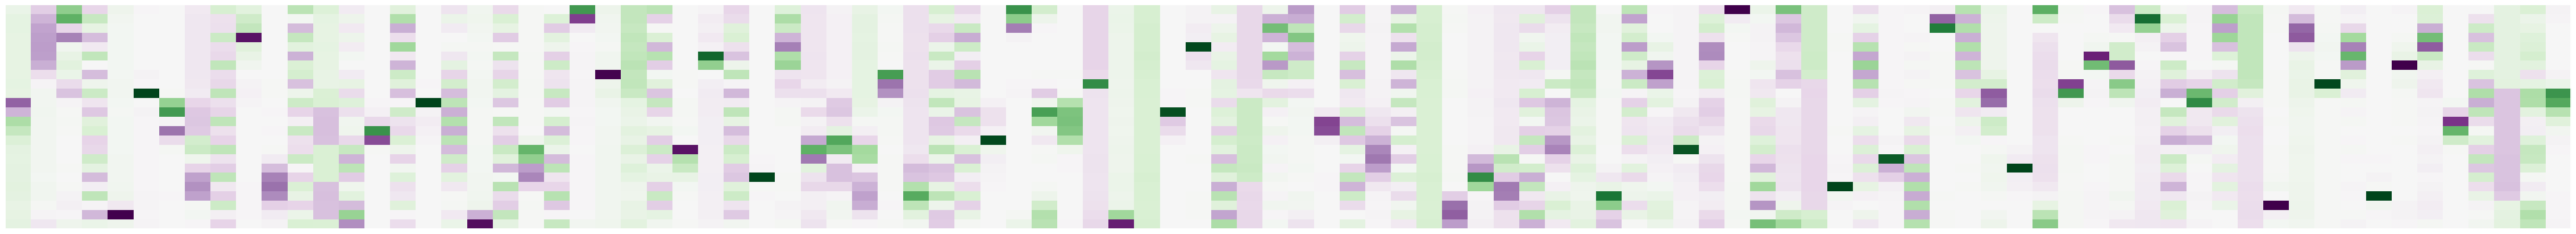

In [257]:
fig, ax = plt.subplots(figsize=(50,5))
fig.tight_layout()
im = ax.imshow(pattern_dictionary, aspect='auto', cmap='PRGn', interpolation='none')
ax.grid(False)
# fig.colorbar(im, ax=ax)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(config_dir, 'visuals', 'pattern_dictionary', 'pattern_dictionary_unsorted.png'))
plt.show()

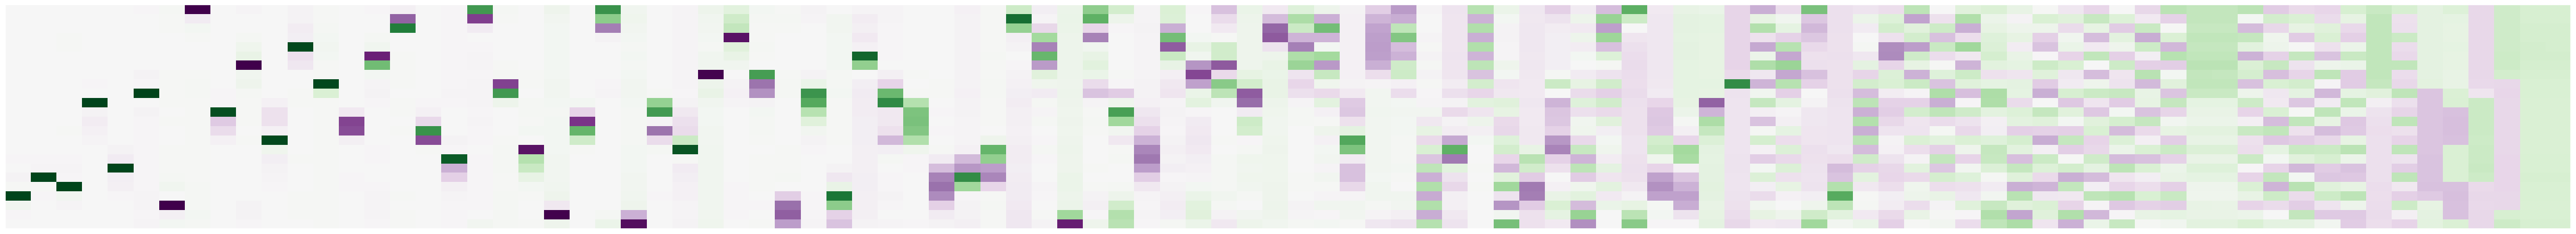

In [258]:
l1_norms = np.linalg.norm(pattern_dictionary, axis=0, ord=1)

fig, ax = plt.subplots(figsize=(50,5))
fig.tight_layout()
im = ax.imshow(pattern_dictionary[:,np.argsort(l1_norms)], aspect='auto', cmap='PRGn', interpolation='none')
ax.grid(False)
# fig.colorbar(im, ax=ax)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(config_dir, 'visuals', 'pattern_dictionary', 'pattern_dictionary_sorted.png'), bbox_inches='tight', pad_inches=0)
plt.show()

In [259]:
covariance_dictionary = [np.outer(u,u) for u in pattern_dictionary.T]

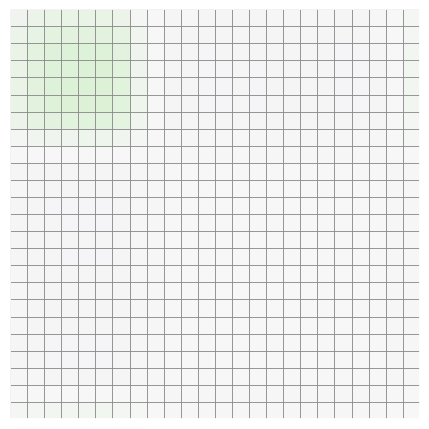

In [260]:
fig, ax = plt.subplots()
fig.tight_layout()
# im = ax.imshow(np.outer(pattern_dictionary[:,0],pattern_dictionary[:,0]), aspect='equal', cmap='PRGn', interpolation='none', )
im = plt.pcolormesh(covariance_dictionary[1], cmap='PRGn', edgecolors='gray', linewidth=0.5, antialiased=True, vmin=-1, vmax=1)
#flip y axis

plt.gca().invert_yaxis()
ax.set_aspect('equal')
ax.grid(False)
#remove x and y ticks
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

In [261]:
## if there is no covariance dictionary folder under visuals, create one
if not os.path.exists(os.path.join(config_dir, 'visuals', 'covariance_dictionary')):
    os.makedirs(os.path.join(config_dir, 'visuals', 'covariance_dictionary'))

In [262]:
## save the covariance dictionary images to the folder
for i in range(len(covariance_dictionary)):
    fig, ax = plt.subplots()
    fig.tight_layout()
    im = plt.pcolormesh(covariance_dictionary[i], cmap='PRGn', edgecolors='gray', linewidth=0.5, antialiased=True, vmin=-1, vmax=1)
    #flip y axis
    plt.gca().invert_yaxis()
    ax.set_aspect('equal')
    ax.grid(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.savefig(os.path.join(config_dir, 'visuals', 'covariance_dictionary', f'covariance_dictionary_{i}.png'))
    plt.close()

In [263]:
## if there is no folder called user_dictionary under visuals, create one
if not os.path.exists(os.path.join(config_dir, 'visuals', 'user_dictionary')):
    os.makedirs(os.path.join(config_dir, 'visuals', 'user_dictionary'))

In [590]:
user_gamma = np.load("/home/kbolat/Python/behavio-temporal-vae/data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_31/user_gamma.npy")

In [591]:
user_gamma.shape

(6830, 100)

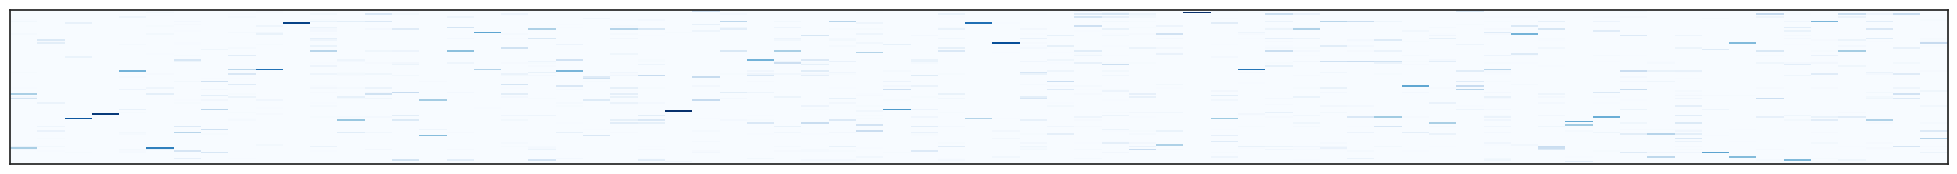

In [592]:
ssample = 97 ## for visualization
fig, ax = plt.subplots(figsize=(25, 2))
plt.pcolormesh(user_gamma[::ssample].T, cmap='Blues')
# ax.set_title(f"Enrolments -  Mean: {365/(1+config['data']['ampute_params']['b']/config['data']['ampute_params']['a']):.1f}")
# ax.set_xlabel("Users")
# ax.set_ylabel("Day")
# plt.gca().invert_yaxis() ## flip the y axis
# plt.yticks(np.arange(0, 365, 30), np.arange(0, 365, 30))
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(config_dir, 'visuals', 'user_dictionary', 'user_gamma.png'), bbox_inches='tight', pad_inches=0)
plt.show()

In [593]:
sns.set_theme(style='white', palette='Paired')

[]

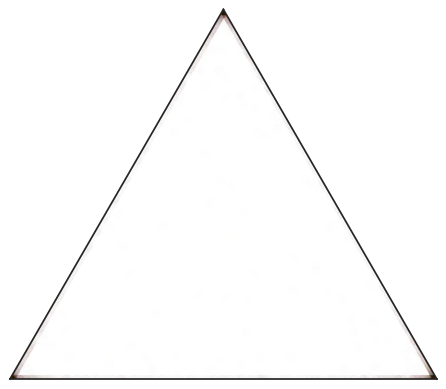

In [595]:
ax = plt.subplot(projection='ternary', ternary_sum=1)

for i in np.argsort(np.linalg.norm(user_gamma, axis=1, ord=2))[5:350:15]:
    ## take dirichlet samples using the user_gamma[i] as the concentration parameter
    sample = np.random.dirichlet(user_gamma[i]/365*(500*np.random.rand()+300), size=1000).T
    ax.scatter(sample[0], sample[1], sample[2], alpha=0.005)
ax.taxis.set_ticks([])
ax.laxis.set_ticks([])
ax.raxis.set_ticks([])

In [596]:
theta_mean = user_gamma / np.sum(user_gamma, axis=1, keepdims=True)

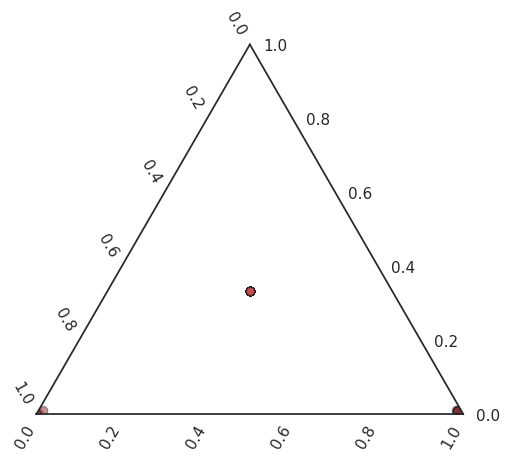

In [597]:
ax = plt.subplot(projection="ternary", ternary_sum=1)
ax.scatter(theta_mean[:,0], theta_mean[:,1], theta_mean[:,2], alpha=0.1, c='r', linewidths=0.9, edgecolors='k')

[]

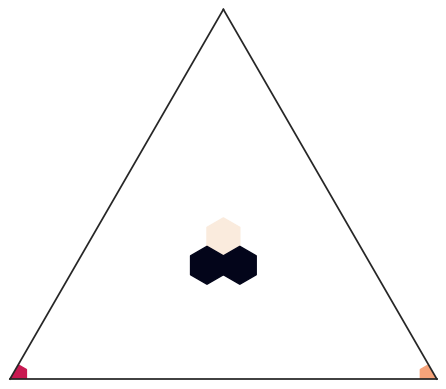

In [598]:
ax = plt.subplot(projection="ternary", ternary_sum=1)
ax.hexbin(theta_mean[:,0], theta_mean[:,1], theta_mean[:,2], gridsize=13, bins='log')
ax.taxis.set_ticks([])
ax.laxis.set_ticks([])
ax.raxis.set_ticks([])

In [599]:
def clr_transformation(data):
    """
    Apply Centered Log-Ratio (CLR) transformation to compositional data.
    """
    geometric_mean = np.exp(np.mean(np.log(data), axis=1, keepdims=True))
    clr_data = np.log(data / geometric_mean)
    return clr_data

In [600]:
def ilr_transformation(data):
    """
    Apply Isometric Log-Ratio (ILR) transformation to compositional data.
    """
    n_samples, n_features = data.shape
    ilr_data = np.zeros((n_samples, n_features - 1))
    
    # Create the Helmert matrix
    helmert_matrix = np.zeros((n_features - 1, n_features))
    for i in range(1, n_features):
        helmert_matrix[i-1, :i] = -1 / i
        helmert_matrix[i-1, i] = i

    # Normalize the Helmert matrix
    helmert_matrix = helmert_matrix / np.sqrt(np.arange(1, n_features) * np.arange(2, n_features + 1))[:, np.newaxis]

    # Apply the ILR transformation
    for i in range(n_samples):
        ilr_data[i, :] = np.dot(helmert_matrix, np.log(data[i, :]))

    return ilr_data

In [605]:
theta_transformed = ilr_transformation(theta_mean)

In [603]:
## apply pca to the clr transformed data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
theta_pca = pca.fit_transform(clr_transformation(theta_mean))



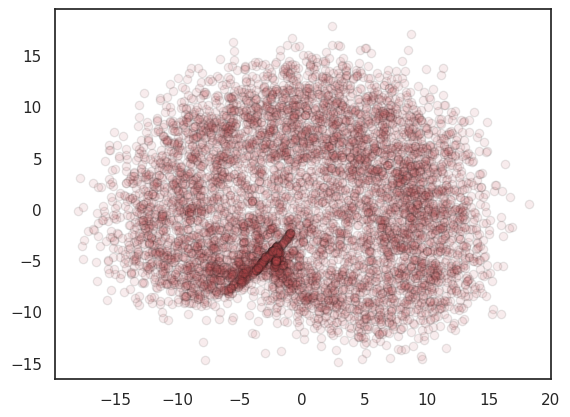

In [604]:
plt.scatter(theta_pca[:,0], theta_pca[:,1], alpha=0.1, c='r', linewidths=0.9, edgecolors='k')

In [609]:
## apply t-SNE to the transformed data
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
theta_tsne = tsne.fit_transform(theta_mean)


ImportError: cannot import name 'UMAP' from 'sklearn.manifold' (/home/kbolat/.conda/envs/torchenv/lib/python3.9/site-packages/sklearn/manifold/__init__.py)

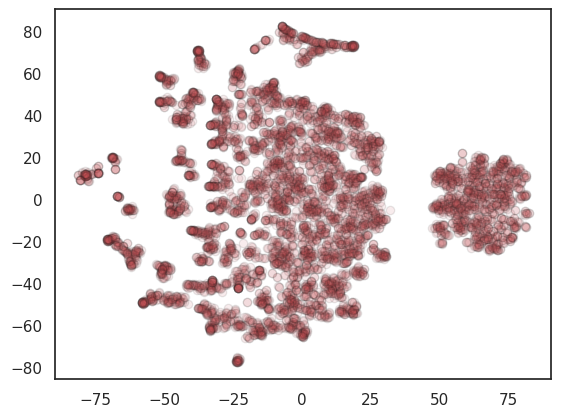

In [608]:
plt.scatter(theta_tsne[:,0], theta_tsne[:,1], alpha=0.1, c='r', linewidths=0.9, edgecolors='k')